# Problème n°2: PointNet

Certains jeux de données impliquent des nuages de points dans un espace 3D. Penser par exemple à un ensemble de mesures lidar : chaque tir permet de renseigner les coordonnées d'un des points de l'objet ciblé.
Une tâche intéressante consiste à classer chacun des points du nuage en fonction de l'objet auquel il appartient. Cette tâche est considérée comme une variante de la segmentation sémantique d'images.

Ce problème introduit à une méthode directe de segmentation d'un nuage par deep learning. Elle est basée sur une architecture particulière appelée PointNet. \
Dans la première partie, on présente un jeu de données (synthétisé à la volée) impliquant des nuages de points.
Dans la seconde partie, on explore la structure et les propriétés de PointNet. Dans la troisième, on l'entraîne et dans la dernière partie, on charge les poids d'une version améliorée de PointNet (PointNet++) pour comparaison.

La cellule suivante permet les imports nécessaires:

In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import matplotlib.pyplot as plt
import os
! pip install einops
! git clone https://github.com/0Yassine0/exam_2025.git
! cp exam_2025/utils/utils_probleme2.py .
from utils_probleme2 import gen_pointcloud, plot_triplets

fatal: destination path 'exam_2025' already exists and is not an empty directory.


## Partie I : un exemple de PointCLoud data

Pour construire le jeu de données, on simule un terrain couvert de deux types de bâtiments : des immeubles de forme rectangulaire aux toits plats et des igloos (dômes). Pour créer les nuages, on échantillonne les surfaces vues du ciel (les murs des bâtiments rectangulaires ne sont pas échantillonnées), en favorisant les zones d'altitude non nulles.
Le but est de distinguer les igloos du reste (sol et toits des bâtiments). Il s'agit donc d'une segmentation binaire.

0


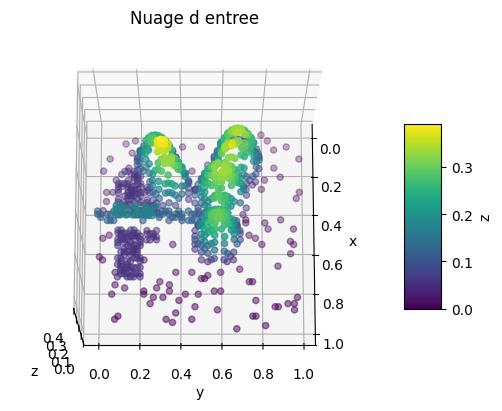

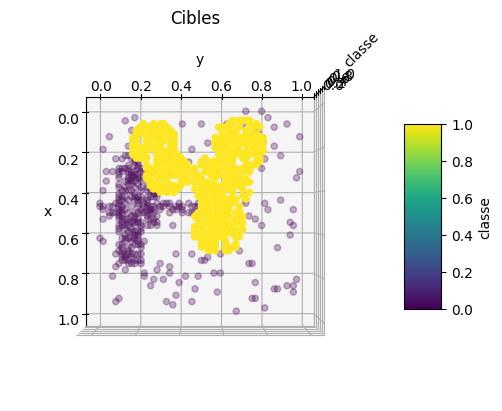

1


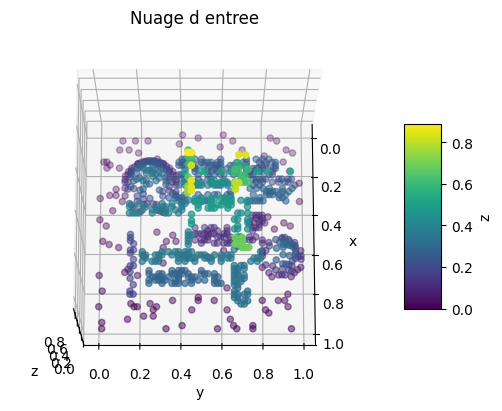

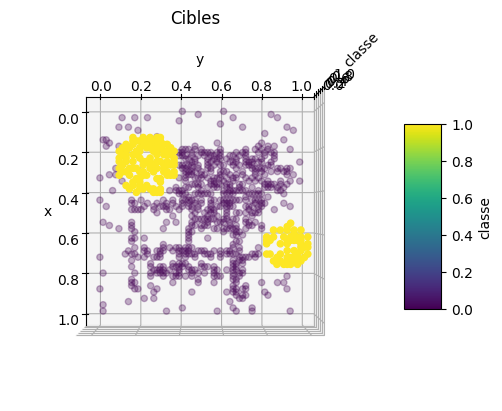

2


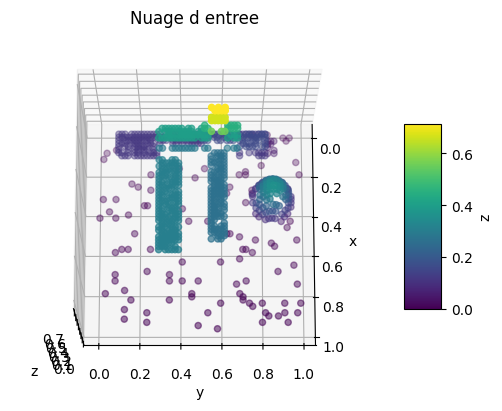

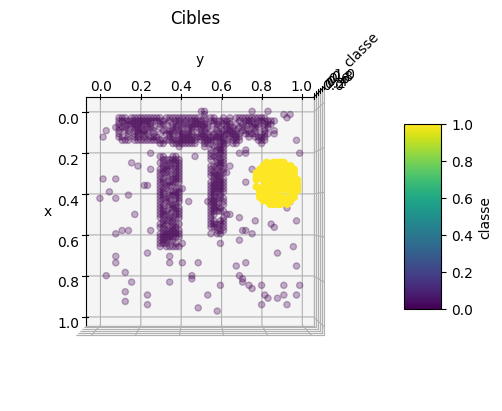

3


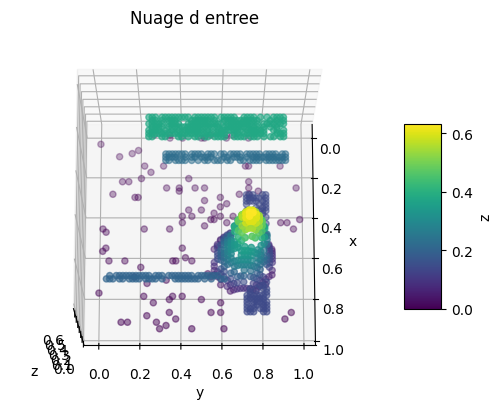

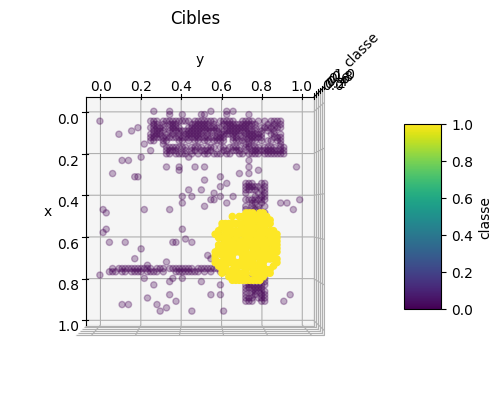

4


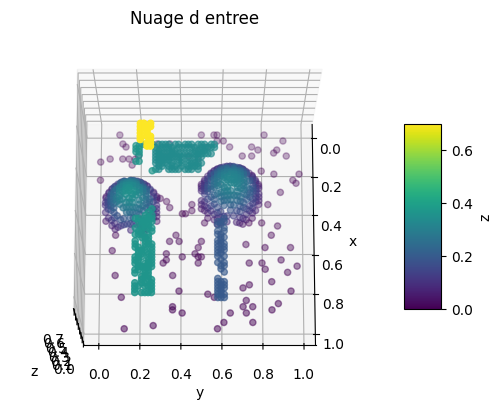

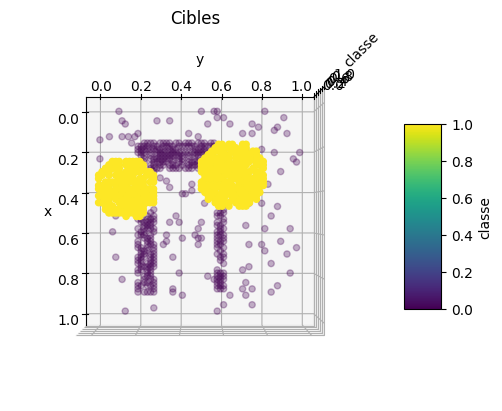

5


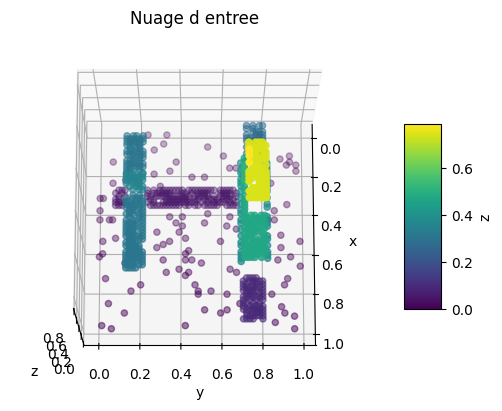

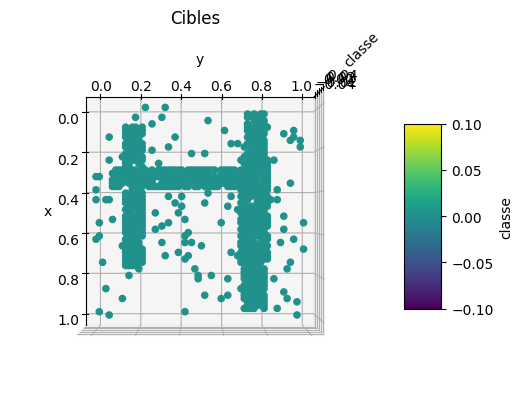

In [26]:
batch_size = 6
input_points, target_list, target_points  = gen_pointcloud(batch_size)


for i in range(batch_size):
  print(i)
  # Représentation 3D des nuages de points et
  # les paramètres elev et azim permettent de changer l'angle de vue
  plot_triplets(input_points[i].transpose(0,1).cpu(),
                elev=75, azim=0)

  # Cibles : les points appartenant aux toitures d'igloos sont
  # dans la classe 1, les autres, dans la classe 0.
  plot_triplets(target_points[i].transpose(0,1).cpu(),
                title='Cibles',
                cbar_label='classe')

  # Note: target_points contient non seulement les classes
  # mais aussi les coordonnées x et y des points, pour
  # faciliter leur visualisation

**Q1** A quoi correspondent les différentes dimensions de *input_points* ?

In [10]:
input_points.shape

torch.Size([6, 3, 800])

la taille de minibatch : 6

les coordonnées de chaque point : 3

le nombre de points d'un nuage : 800



**Q2** Les points d'un nuage sont-ils rangés dans un ordre particulier ?


non, les points d'un nuage généré par gen_pointcloud ne sont pas rangés dans un ordre particulie

**Q3** (question ouverte). Si vous deviez traiter le problème avec un FCN ou un ViT (Visual Transformer), que feriez-vous ?

Pour utiliser un FCN ou un ViT, il faudrait transformer le nuage de points en une représentation 2D, comme une image. on pourrait par exemple projeter le nuage de points sur un plan pour obtenir une image de profondeur.

## Partie II : le modèle PointNet

Dans cette partie, on s'intéresse à la propriété principale d'un réseau PointNet : l'utilisation d'opérations invariantes par rapport à l'ordre dans lequel les points sont présentés au réseau.

In [28]:
from utils_probleme2 import PointNetSegHead, PointNetSegLoss
pointnet = PointNetSegHead(num_points=800, num_global_feats=1024, m=2).cuda()

input_points, target_list, _ = gen_pointcloud(batch_size)
input_points = input_points.cuda()
outputs, _, _ = pointnet(input_points)

**Q1** La sortie du modèle PointNet correspond au premier tenseur du *tuple* fourni la fonction *forward* de *pointnet*. A quoi correspondent les différentes dimensions de *output* ? Quel est l'effet d'une permutation des points contenus dans *inputs_points* sur la sortie ? Répondre :

- en vous référant à l'article [l'article](https://arxiv.org/abs/1612.00593) qui introduit ce réseau (citer dans le texte).
- à partir de tests à effectuer dans la cellule de code suivante (utiliser torch.randperm pour générer des permutations sur les entrées)

Selon l'article, "PointNet est conçu pour être invariant à l'ordre des points dans l'ensemble d'entrée." Cela signifie que la permutation de l'ordre des points dans input_points ne devrait pas affecter significativement la sortie.

In [29]:

# Generate random permutation
idx = torch.randperm(input_points.shape[1])

# Permute the input points
permuted_input = input_points[:, idx, :]

# Get the output for the permuted input
permuted_output, _, _ = pointnet(permuted_input)

# Compare the original output with the permuted output
# You can use a metric like mean squared error (MSE) for comparison
mse = torch.nn.functional.mse_loss(outputs, permuted_output)

# Print the MSE to see the difference
print(mse)

tensor(0.6570, device='cuda:0', grad_fn=<MseLossBackward0>)


**Q2** L'architecture de *pointnet* est décrite dans la Figure 2 de l'article (voir ci-dessous) évoqué à la question précédente. En dehors des opérations notées "input transform" et "feature transform", dont la compréhension est plus délicate, quelles sont les différentes opérations conduisant à une segmentation ? Que signifie le terme "shared" et expliquer en quoi ces opérations sont invariantes par rapport à l'ordre de présentation des points.

<img src= https://miro.medium.com/v2/resize:fit:1100/format:webp/1*lFnrIqmV_47iRvQcY3dB7Q.png >

## Partie III

Dans cette partie, on se propose d'entraîner un PointNet. Pour ce faire, on utilisera une fonction de coût spécifique (voir cellule ci-dessous).

**Consignes :**

1) Entraîner un PointNet sur quelques centaines d'époques.

2) Afficher à chaque époque la justesse des prédictions

3) Charger les poids d'un réseau entraîné sur 500 époques, stockés dans le fichier **pointnet_500_ep.pth** du répertoire https://huggingface.co/nanopiero/pointnet_igloos.

Visualiser les sorties de ce modèle-là en complétant le la dernière cellule de code du calepin.


In [34]:
optimizer = torch.optim.Adam(pointnet.parameters(),
                             lr=0.0001, betas=(0.9, 0.999))

# manually set alpha weights
alpha = np.array([0.2, 0.8])
gamma = 1
loss_fn = torch.nn.CrossEntropyLoss()


# exemple d'utilisation de PointNetSegLoss:
# La transposition permet de repasser la dimension relative
# aux probabilités en dernier, comme avec torch.nn.CrossEntropyLoss
#proba_pred_list = outputs.transpose(1,2)
#loss_fn(proba_pred_list, target_list)

In [37]:
batch_size = 64
n_epochs = 200
n_batch_per_epoch = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in range(1, n_epochs):
  print('epoch : ', epoch)
  for batch in range(1,n_batch_per_epoch):
     # Génération de données
      input_points, target_list, _ = gen_pointcloud(batch_size)
      input_points, target_list = input_points.to(device), target_list.to(device)

      # Prédictions
      outputs, _, _ = pointnet(input_points)
      proba_pred_list = outputs.transpose(1, 2)

      # Calcul de la perte
      loss = loss_fn(proba_pred_list, target_list)

      # Mise à jour des poids
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    # Calcul de la justesse pour cette époque
  with torch.no_grad():
        input_points, target_list, _ = gen_pointcloud(batch_size)
        input_points, target_list = input_points.to(device), target_list.to(device)
        outputs, _, _ = pointnet(input_points)
        pred_list = outputs.transpose(1, 2).max(1)[1]
        accuracy = (pred_list == target_list).float().mean().item()
        print(f"Justesse: {accuracy}")


epoch :  1
Justesse: 0.5038085579872131
epoch :  2
Justesse: 0.5029101371765137
epoch :  3
Justesse: 0.4870898425579071
epoch :  4
Justesse: 0.5077343583106995
epoch :  5
Justesse: 0.5102148056030273
epoch :  6
Justesse: 0.49595701694488525
epoch :  7
Justesse: 0.5013476610183716
epoch :  8
Justesse: 0.505664050579071
epoch :  9
Justesse: 0.5321679711341858
epoch :  10
Justesse: 0.5704687237739563
epoch :  11
Justesse: 0.5132030844688416
epoch :  12
Justesse: 0.5389843583106995
epoch :  13
Justesse: 0.5645117163658142
epoch :  14
Justesse: 0.548144519329071
epoch :  15
Justesse: 0.5750585794448853
epoch :  16
Justesse: 0.5671093463897705
epoch :  17
Justesse: 0.5926952958106995
epoch :  18
Justesse: 0.6005468368530273
epoch :  19
Justesse: 0.5708398222923279
epoch :  20
Justesse: 0.6039843559265137
epoch :  21
Justesse: 0.5912109017372131
epoch :  22
Justesse: 0.5946093797683716
epoch :  23
Justesse: 0.5746288895606995
epoch :  24
Justesse: 0.6487694978713989
epoch :  25
Justesse: 0.63

0


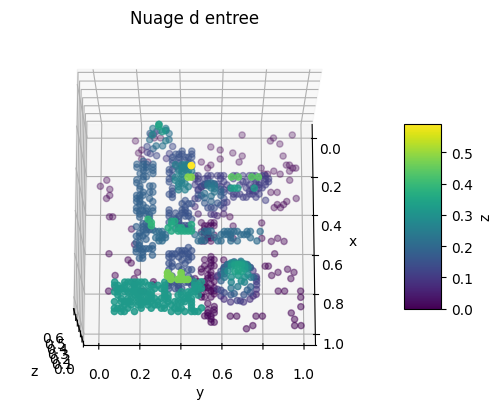

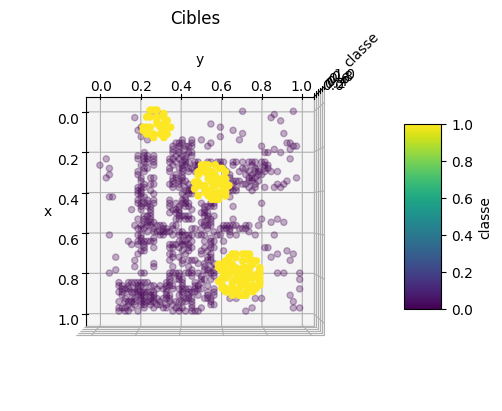

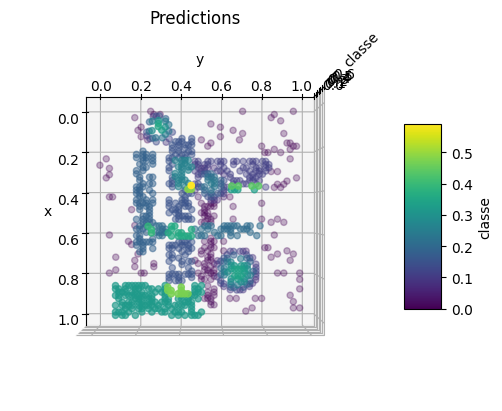

1


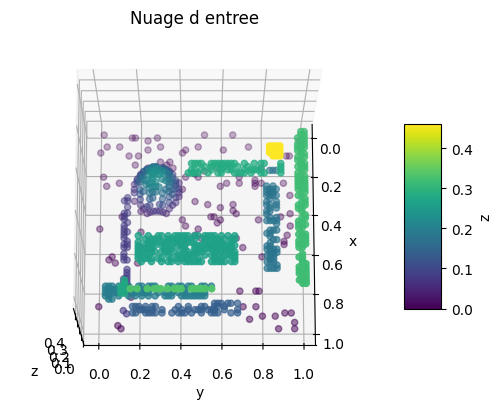

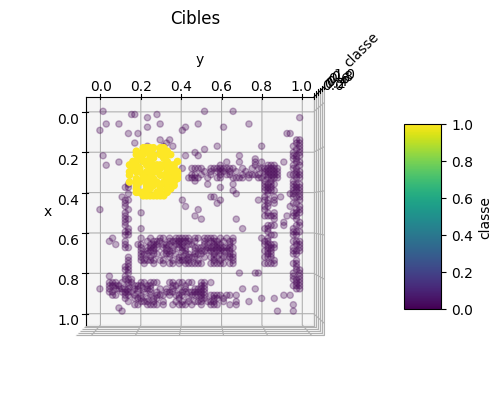

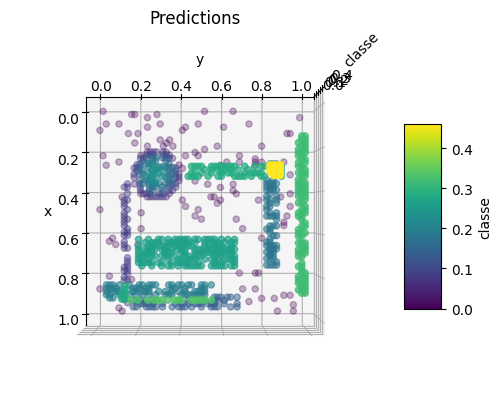

2


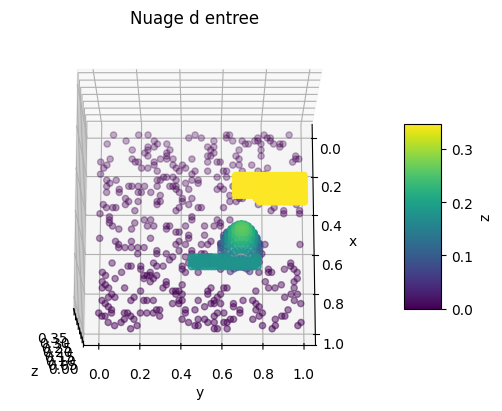

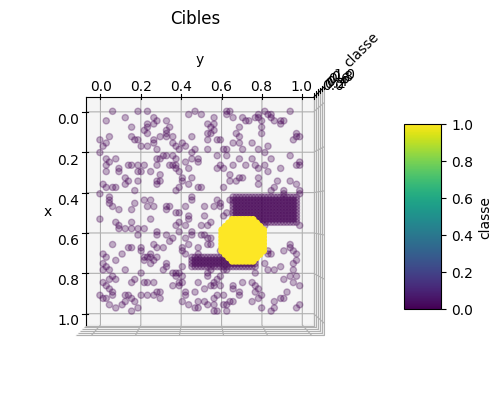

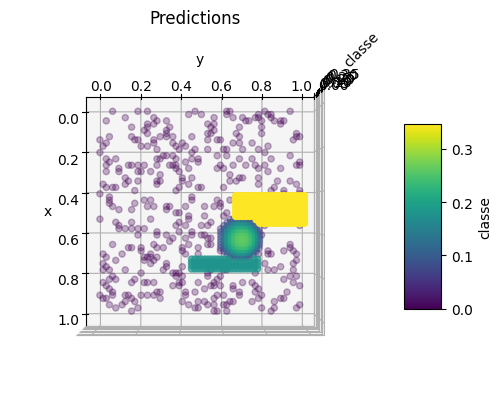

3


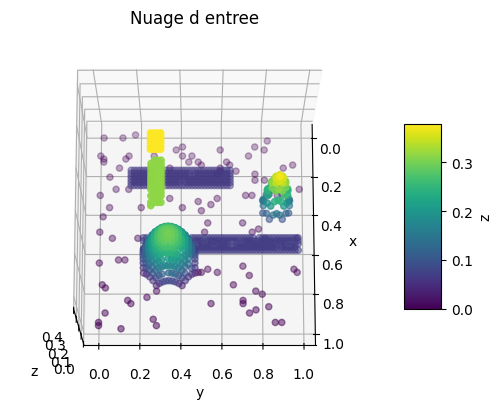

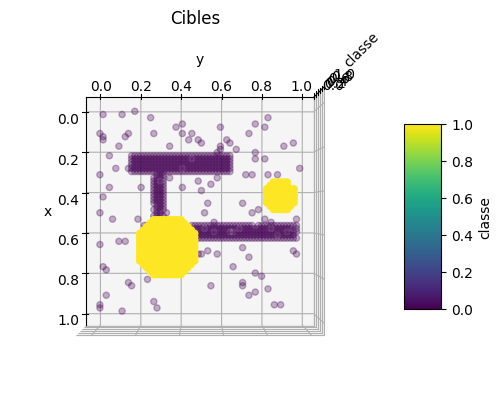

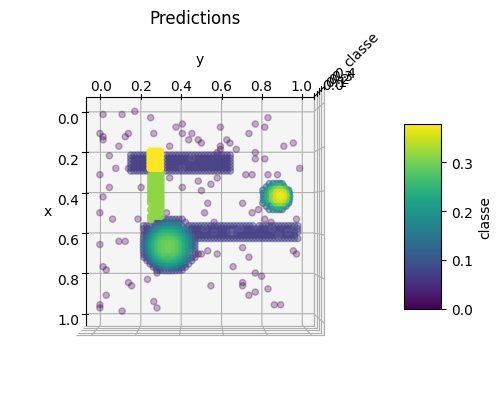

4


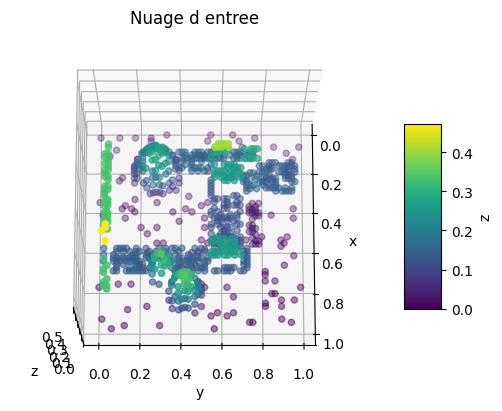

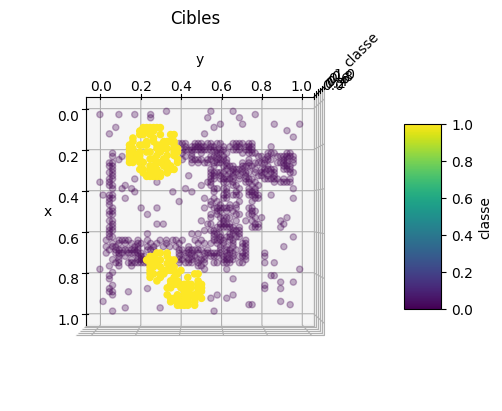

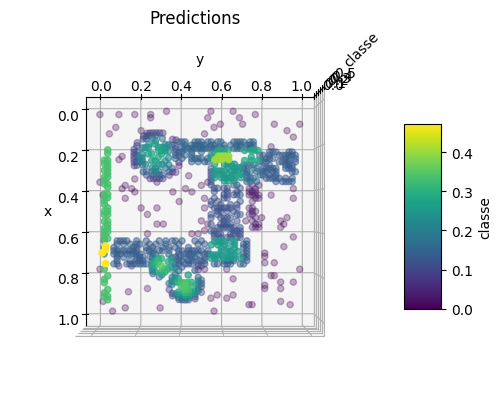

5


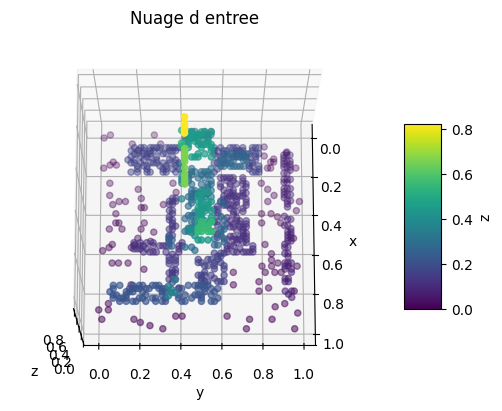

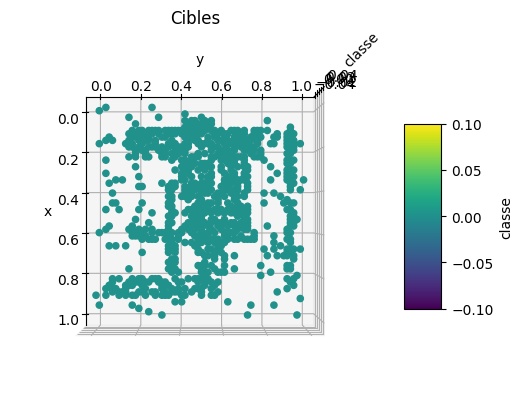

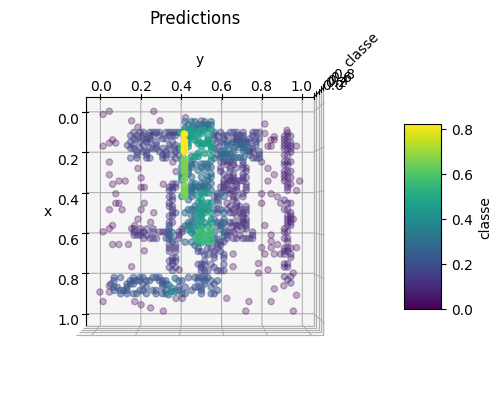

In [38]:
input_points, target_list , target_points = gen_pointcloud(6)

# Il faut construire les prédictions.
proba_pred_list, _, _ = pointnet.cuda()(input_points.to(device))
pred_list = proba_pred_list.transpose(1,2).max(1)[1].cpu()

# Accuracy:
...
# Tracé

for i in range(6):
  print(i)
  plot_triplets(input_points[i].transpose(0,1), elev=75, azim=0)
  plot_triplets(target_points[i].transpose(0,1),
                title='Cibles',
                cbar_label='classe')
  plot_triplets(
                torch.cat([input_points[i].transpose(0, 1).cpu(), pred_list[i].unsqueeze(1).float()], dim=1),
                title='Predictions',
                cbar_label='classe')
